## Import all what we need.

In [1]:
# encoding: utf-8
import os
import bz2
import csv
import glob
import time
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from numba import jit
from io import StringIO
import matplotlib.pyplot as plt
import threading, multiprocessing

## The Input File Path and Parameters


<table><tr><td bgcolor=skyblue><font size=24> Could be changed ! </font></td></tr></table>

In [2]:
#########################################################
inp_filepath = 'CO2.inp'
read_path = '/mnt/data/exomol/exomol3_data/'

ratio = 1.0
ratio_air = 0.7
ratio_self = 0.3
cutoff = 25.0
threshold = 1e-30
P = 1.0
#########################################################

## Report time

In [3]:
class Timer:    
    def start(self):
        self.start_CPU = time.clock()
        self.start_sys = time.time()
        return self

    def end(self, *args):
        self.end_CPU = time.clock()
        self.end_sys = time.time()
        self.interval_CPU = self.end_CPU - self.start_CPU
        self.interval_sys = self.end_sys - self.start_sys
        print('{:25s} : {}'.format('Running time on CPU', self.interval_CPU), 's')
        print('{:25s} : {}'.format('Running time on system', self.interval_sys), 's')

## Read Information from Input File

In [4]:
def inp_para(inp_filepath):
    
    inp_col_name = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9','c10']
    inp_df = pd.read_csv(inp_filepath, sep='\\s+', names=inp_col_name, header=None)
    col0 = inp_df['c0']
    database = inp_df[col0.isin(['Database'])]['c1'].values[0]
    molecule = inp_df[col0.isin(['Molecule'])]['c1'].values[0]
    isotopologue = inp_df[col0.isin(['Isotopologue'])]['c1'].values
    dataset = inp_df[col0.isin(['Dataset'])]['c1'].values
    mol_iso_id = int(inp_df[col0.isin(['mol_iso_id'])]['c1'])
    T = int(inp_df[col0.isin(['Temperature'])]['c1'])
    min_wn = float(inp_df[col0.isin(['Range'])]['c1'])
    max_wn = float(inp_df[col0.isin(['Range'])]['c2'])
    N_point = int(inp_df[col0.isin(['Npoints'])]['c1'])
    profile = inp_df[col0.isin(['Profile'])]['c1'].values[0]
    wn_wl = inp_df[col0.isin(['Wavenumber(wn)/wavelength(wl)'])]['c1'].values[0]
    saveplots = inp_df[col0.isin(['SavePlots'])]['c1'].values[0]
    savexsecs = inp_df[col0.isin(['SaveXsecs'])]['c1'].values[0]

    molecule_id = int(mol_iso_id/10)
    isotopologue_id = mol_iso_id - molecule_id * 10
    isometa_url = 'https://hitran.org/docs/iso-meta/'
    iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
    iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
    abundance = float(iso_meta_row['Abundance'][0].replace('\xa0×\xa010','E'))
    mass = float(iso_meta_row['Molar Mass /g·mol-1'])
    
    return database, molecule, isotopologue, dataset, T, min_wn, max_wn, N_point, profile, wn_wl, saveplots, savexsecs, molecule_id, isotopologue_id, abundance, mass


## Constants and Parameters

In [5]:
# Parameters for calculating.
import astropy.constants as ac
(database, molecule, isotopologue, dataset, T, min_wn, max_wn, N_point, profile, wn_wl, 
saveplots, savexsecs, molecule_id, isotopologue_id, abundance, mass) = inp_para(inp_filepath)
T_ref = 296.0                   # Reference temperature is 296 K.
P_ref = 1.0                     # Reference pressure is 1 atm.
N_A = ac.N_A.value              # Avogadro number (mol^{-1})
h = ac.h.to('J s').value        # Planck's const (J s)
c = ac.c.to('cm/s').value       # Velocity of light (cm s^{-1})
kB = ac.k_B.to('J/K').value     # Boltzmann's const (J K^{-1})
c2 = h * c / kB                 # Second radiation constant (cm K)
c2_T = c2 / T                   # c2 / T (cm)
c2_T_ref = c2 / T_ref           # c2 / T_ref (cm)
pi_c_8 = 1 / (8 * np.pi * c)    # 8 * pi * c (cm-1 s)

## Read ExoMol Format Input File

Read the parameters of the linelist in ExoMol format text file. Return the dataframe of the linelist data for the following calculations.

In [6]:
def read_all_states(read_path):
    
    s_df = dict()
    states_df = pd.DataFrame()
    states_filenames = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset 
                                  + '/' + isotopologue + '__' + dataset + '.states.bz2')[0])

    for states_filename in states_filenames:
        s_df[states_filename] = pd.read_csv(states_filename, compression='bz2', sep='\s+', header=None,
                                            chunksize=100_000_000, iterator=True, low_memory=False)
        for chunk in s_df[states_filename]:
            # Extract rows of states file whose uncertainty indices are small than 0.01.
            #chunk = chunk[chunk[4] < float(0.01)]
            states_df = states_df.append(chunk)
            
    pd.set_option("display.max_columns",30)                           
    return(states_df)

In [7]:
read_all_states(read_path)

/tmp/ipykernel_1227449/4222175214.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  states_df = states_df.append(chunk)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,0.000000,1,0,0.005,A1,e,0,0,0,0,1.00,0,0,0,0,1,0,0,0,HI,0.000000
1,2,1285.408201,1,0,0.005,A1,e,0,2,0,0,1.00,1,0,0,0,2,0,0,1,HI,1285.407985
2,3,1388.184200,1,0,0.005,A1,e,1,0,0,0,1.00,1,0,0,0,1,1,0,0,HI,1388.184961
3,4,2548.366701,1,0,0.005,A1,e,1,2,0,0,1.00,2,0,0,0,3,1,0,1,HI,2548.366797
4,5,2671.143002,1,0,0.005,A1,e,2,0,0,0,1.00,2,0,0,0,2,1,1,0,HI,2671.143759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3562793,3562794,35978.691717,461,230,5.440,A2,f,6,5,1,2,-0.14,-1,-1,-1,-1,-1,8,0,2,Ca,35978.691717
3562794,3562795,35988.745907,461,230,5.450,A2,f,3,10,10,1,-0.10,-1,-1,-1,-1,-1,0,4,0,Ca,35988.745907
3562795,3562796,35993.485056,461,230,5.520,A2,f,0,21,17,0,-0.26,-1,-1,-1,-1,-1,0,0,2,Ca,35993.485056
3562796,3562797,35995.769076,461,230,5.450,A2,f,3,10,10,1,0.10,-1,-1,-1,-1,-1,0,4,0,Ca,35995.769076


In [8]:
def read_all_trans(read_path):
    
    t_df = dict()
    trans_df = pd.DataFrame()
    trans_col_name = ['i', 'f', 'A_if', 'v_if']
    trans_filenames = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')[0])

    for trans_filename in trans_filenames:
        t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None,
                                           names=trans_col_name, chunksize=100_000_000, iterator=True, low_memory=False)
        for chunk in t_df[trans_filename]:
            trans_df = trans_df.append(chunk)
            
    pd.set_option("display.max_columns",30)                           
    return(trans_df)
    

In [ ]:
read_all_trans(read_path)

In [ ]:
def read_part_trans(transfile_df):
    trans_df = transfile_df[transfile_df['v_if'].between(min_wn - cutoff, max_wn + cutoff)]
    return (trans_df)

def read_part_trans(read_path):
    t_df = dict()
    trans_df = pd.DataFrame()
    lower_df = pd.DataFrame()
    upper_df = pd.DataFrame()
    insider_df = pd.DataFrame()
    trans_col_name = ['i', 'f', 'A_if', 'v_if']
    trans_filenames = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')[0])

    if len(trans_filenames) == 1:
        t_df = pd.read_csv(trans_filenames[0], compression='bz2', sep='\s+', header=None, 
                           names=trans_col_name, chunksize=100_000_000, encoding='utf-8')
        for chunk in t_df:
            chunk = chunk[chunk['v_if'].between(min_wn - cutoff, max_wn + cutoff)]
            trans_df = trans_df.append(chunk)
        
    elif len(trans_filenames) > 1:
        for trans_filename in tqdm(trans_filenames):
            lower = int(trans_filename.split('__')[2].split('.')[0].split('-')[0])
            upper = int(trans_filename.split('__')[2].split('.')[0].split('-')[1])
            if (lower <= int(min_wn) <= upper):
                file_lower = pd.read_csv(trans_filename, compression='bz2', sep='\s+', names=trans_col_name, 
                                         header=None, chunksize=100_000_000, encoding='utf-8')
                for chunk in file_lower:
                    chunk = chunk[chunk['v_if'].between(min_wn - cutoff, max_wn + cutoff)]
                    lower_df = trans_df.append(chunk)

            elif (lower <= int(min_wn) <= upper):
                file_upper = pd.read_csv(trans_filename, compression='bz2', sep='\s+', names=trans_col_name, 
                                         header=None, chunksize=100_000_000, encoding='utf-8')
                for chunk in file_upper:
                    chunk = chunk[chunk['v_if'].between(min_wn - cutoff, max_wn + cutoff)]                 
                    upper_df = trans_df.append(chunk)

            elif (lower >= int(min_wn) and upper <= int(max_wn)):    
                t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', names=trans_col_name, 
                                                   header=None, chunksize=100_000_000, encoding='utf-8')
                for chunk in tqdm(t_df[trans_filename]):
                    insider_df = trans_df.append(chunk)       

        trans_df = lower_df.append(insider_df).append(upper_df)
    
    else:
        print('No transitions file here.')
    return (trans_df)

In [ ]:
def read_web_pf(T_ref, T):
    
    pf_url = ('http://www.exomol.com/db/' + molecule + '/' + isotopologue + '/' + dataset 
              + '/' + isotopologue + '__' + dataset + '.pf')[0]
    pf_content = requests.get(pf_url).text
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(StringIO(pf_content), sep='\\s+', names=pf_col_name, header=None)
    Q_ref = pf_df['Q'][T_ref-1]
    Q = pf_df['Q'][T-1]

    return(Q_ref, Q)

In [9]:
def read_pf(read_path, T_ref, T):
    
    pf_filename = (read_path + molecule + '/' + isotopologue + '/' + dataset 
                   + '/' + isotopologue + '__' + dataset + '.pf')[0]
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(pf_filename, sep='\\s+', names=pf_col_name, header=None)
    Q_ref = pf_df['Q'][T_ref-1]
    Q = pf_df['Q'][T-1]

    return(Q_ref, Q)

In [10]:
def read_broad(read_path):
    
    broad_col_name = ['code', 'gamma_L', 'n_air', 'Jpp']
    broad_path = (read_path + molecule + '/' + isotopologue + '/' + isotopologue + '__air.broad')[0]
    broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
    return(broad_df)

In [11]:
def all_linelist(read_path):
    states_df = read_all_states(read_path)
    trans_df = read_all_trans(read_path)
    
    id_i = trans_df['i'].values
    id_f = trans_df['f'].values
    states_i_df = states_df.iloc[id_i-1]
    #states_f_df = states_df.iloc[id_f-1]
    
    linelist_df = pd.DataFrame()
    linelist_df['i'] = trans_df['i']
    linelist_df['f'] = trans_df['f']
    linelist_df['A'] = trans_df['A_if']
    linelist_df['v'] = trans_df['v_if']
    linelist_df['Ep'] = states_i_df[1].values
    linelist_df['gp'] = states_i_df[2].values
    
    return linelist_df


In [12]:
all_linelist_df = all_linelist(read_path)
all_linelist_df

,i,f,A,v,Ep,gp
0,200,303,1.683600e-28,0.000011,51758.545382,12
1,202,305,1.287100e-28,0.000011,51836.445168,12
2,206,309,1.818900e-28,0.000011,52027.855858,12
3,188,291,5.813000e-26,0.000012,51035.893950,12
4,190,293,1.865400e-26,0.000012,51305.627368,12
...,...,...,...,...,...,...
2280361,14152,13893,3.609900e-17,40026.317941,50572.228642,486
2280362,14087,14223,4.034600e-15,40028.429745,51097.881881,486
2280363,14153,14157,4.035300e-15,40028.732188,51098.237842,486
2280364,14416,14158,2.539700e-18,40039.004060,51401.261539,498


def part_linelist(read_path):
    states_df = read_all_states(read_path)
    trans_df = read_part_trans(read_path)
    broad_df = read_broad(read_path)
    
    id_i = trans_df['i'].values
    id_f = trans_df['f'].values
    states_i_df = states_df.iloc[id_i-1]
    states_f_df = states_df.iloc[id_f-1]
    max_broad_J = max(broad_df['Jpp'])
    
    linelist_df = pd.DataFrame()
    linelist_df['i'] = trans_df['i']
    linelist_df['f'] = trans_df['f']
    linelist_df['A'] = trans_df['A_if']
    linelist_df['v'] = trans_df['v_if']
    linelist_df['Ep'] = states_i_df[1].values
    linelist_df['Epp'] = states_f_df[1].values
    linelist_df['gp'] = states_i_df[2].values
    #linelist_df['gpp'] = states_f_df[2].values
    linelist_df['Jpp'] = states_f_df[3].values
    linelist_df['Jpp'][linelist_df.Jpp > max_broad_J] = max_broad_J
    id_broad = linelist_df['Jpp'] - 0.5
    linelist_df['gamma_L'] = broad_df['gamma_L'][id_broad].values
    linelist_df['n_air'] = broad_df['n_air'][id_broad].values
    
    return linelist_df


linelist_df = part_linelist(read_path)
linelist_df

def part_linelist(read_path):
    states_df = read_all_states(read_path)
    trans_df = read_part_trans(read_path)
    broad_df = read_broad(read_path)
    
    id_i = trans_df['i'].values
    id_f = trans_df['f'].values
    states_i_df = states_df.iloc[id_i-1]
    states_f_df = states_df.iloc[id_f-1]
    max_broad_J = max(broad_df['Jpp'])
    
    linelist_df = pd.DataFrame()
    linelist_df['i'] = trans_df['i']
    linelist_df['f'] = trans_df['f']
    linelist_df['A'] = trans_df['A_if']
    linelist_df['v'] = trans_df['v_if']
    linelist_df['Ep'] = states_i_df[1].values
    linelist_df['Epp'] = states_f_df[1].values
    linelist_df['gp'] = states_i_df[2].values
    #linelist_df['gpp'] = states_f_df[2].values
    linelist_df['Jpp'] = states_f_df[3].values
    linelist_df['Jpp'][linelist_df.Jpp > max_broad_J] = max_broad_J
    id_broad = linelist_df['Jpp'] - 0.5
    linelist_df['gamma_L'] = broad_df['gamma_L'][id_broad].values
    linelist_df['n_air'] = broad_df['n_air'][id_broad].values
    
    return linelist_df


In [13]:
def part_linelist(states_df, trans_df, broad_df):
    
    id_i = trans_df['i'].values
    id_f = trans_df['f'].values
    states_i_df = states_df.iloc[id_i-1]
    states_f_df = states_df.iloc[id_f-1]
    A = trans_df['A_if'].values
    v = trans_df['v_if'].values
    Ep = states_i_df[1].values
    Epp = states_f_df[1].values
    gp = states_i_df[2].values.astype(float)
    #gpp = states_f_df[2].values
    linelist_df = pd.DataFrame()
    max_broad_J = max(broad_df['Jpp'])
    linelist_df['Jpp'] = states_f_df[3].values
    linelist_df['Jpp'][linelist_df.Jpp > max_broad_J] = max_broad_J
    Jpp = linelist_df['Jpp'].values
    id_broad = linelist_df['Jpp'] - 0.5
    gamma_L = broad_df['gamma_L'][id_broad].values
    n_air = broad_df['n_air'][id_broad].values
    wn_grid = np.linspace(min_wn, max_wn, N_point)
    
    return (wn_grid, A, v, Ep, Epp, gp, Jpp, gamma_L, n_air)

# Parition Function


In [ ]:
# Partition function
def exomol_partition_func(read_path):
    start = time.clock()
    
    states_df = read_all_states(read_path)
    E_n = states_df[1]
    g_n = states_df[2]
    #J_n = states_df[3]
    pf_list = []

    for T in (range(0, Tmax+1, Ntemp)):
        partition_func_1 = np.sum(g_n * np.exp(-c2 * E_n / T))
        partition_func_2 = np.sum(g_n * (c2 * E_n / T) * np.exp(-c2 * E_n / T))
        partition_func_3 = np.sum(g_n * (c2 * E_n / T) ** 2 * np.exp(-c2 * E_n / T))
        
        pf_list.append(str(format(T, '13.3f') + ' ' + format(partition_func_1, '20.8E') + ' ' + format(partition_func_2, '20.8E') + ' ' + format(partition_func_3, '20.8E')))
        
    pf_path = (isotopologue + '__' + dataset + '.pf')[0]
 
    with open(pf_path, 'w') as pf_file:
        for pf in pf_list:
            pf_file.write(pf + '\n')
        pf_file.close()
    
    end = time.clock()
    t = end - start
    print('Running time :', t, 's')
    print('Partition function has been saved!')  


In [ ]:
Ntemp = 1
Tmax = int(5000.00)

exomol_partition_func(read_path)

# Cooling Function

In [ ]:
# Cooling function
def exomol_cooling_func(read_path):
    start = time.clock()
    
    linelist_df = all_linelist(read_path)
    A = linelist_df['A']
    v = linelist_df['v']
    Ep = linelist_df['Ep']      # Lower state energy
    gp = linelist_df['gp']      # Total degeneracy of lower state 
    cf_list = []
    for T in (range(Ntemp, Tmax+1, Ntemp)):
        Q_ref, Q = read_pf(read_path, T_ref, T)
        cooling_func = np.sum(A * h * c * v * gp * np.exp(-c2 * Ep / T)) / (4 * np.pi * Q) * 1e7
        cf_list.append(str(format(T, '13.3f') + ' ' + format(cooling_func, '20.8E')))
  
    cf_path = (isotopologue + '__' + dataset + '.cooling')[0]
    
    with open(cf_path, 'w') as cf_file:
        for cf in cf_list:
            cf_file.write(cf + '\n')
        cf_file.close()
        
    end = time.clock()
    t = end - start
    print('Running time :', t, 's')
    print('Cooling function has been saved!')   
    


In [ ]:
Ntemp = 1
Tmax = int(500.00)

exomol_cooling_func(read_path)

# Lifetime

In [ ]:
# Lifetime
def exomol_lifetime(read_path):
    start = time.clock()
    
    states_df = read_all_states(read_path)
    trans_df = read_all_trans(read_path)
    sum_A = trans_df.groupby('i')['A_if'].sum()
    lifetime = 1 / sum_A
    lt_df = lifetime.map('{: >12.4E}'.format).reset_index()
    states_trans_df = states_df[0].append(lt_df['i'])
    states_trans_df = states_trans_df.drop_duplicates(keep=False)
    add_i = pd.DataFrame()
    add_i['i'] = states_trans_df
    add_i['A_if'] = ' -1.0000E+00'
    lifetime_df = lt_df.append(add_i, ignore_index=True)
    lifetime_df.sort_values('i',inplace=True)
    states_df.insert(col_n, 'lifetime', lifetime_df['A_if'].tolist())
    
    end = time.clock()
    t = end - start
    
    return(states_df)

In [ ]:
col_n = 5

lifetime = exomol_lifetime(read_path)
lifetime

In [ ]:
lt_path = (isotopologue + '__' + dataset + '.csv')[0]

lifetime.to_csv(lt_path, header=None, index=False, chunksize = 1000)
print('lifetime has been saved!')   

## Line Profile

In [14]:
@jit("(float64[:](float64[:], float64, float64))", nopython=True)
def Doppler_HWHM (v, mass, T):
    '''Return the Doppler half-width at half-maximum (HWHM) -- alpha.'''
    alpha = np.sqrt(2 * N_A * kB * T * np.log(2) / mass) * v / c
    return alpha

In [15]:
@jit("(float64[:](float64, float64, float64[:], float64[:]))", nopython=True)
def Lorentzian_HWHM (T, P, n_air, gamma_L):
    '''Return the Lorentzian half-width at half-maximum (HWHM) -- gamma.'''
    #gamma = ((T_ref / T)**n_air * gamma_air * ratio_air + (T_ref / T)**n_self * gamma_self * ratio_self)  * (P / P_ref)
    gamma = gamma_L * ratio * (T_ref / T)**n_air * (P / P_ref)
    
    return gamma

In [16]:
@jit("float64[:](float64[:], float64[:])", nopython=True)
def Gaussian_profile(dv, alpha):
    '''Return Gaussian line profile at dv with HWHM alpha.'''
    alpha = alpha * 2
    Gaussian_profile = np.sqrt(np.log(2) / np.pi) / alpha * np.exp(-np.log(2) * (dv / alpha)**2)
    #Gaussian_profile = np.exp(-(dv / alpha)**2 / 2) / alpha / np.sqrt(2 * np.pi)
    return Gaussian_profile

In [17]:
@jit("(float64[:](float64[:], float64[:]))", nopython=True)
def Lorentzian_profile(dv, gamma):
    '''Return Lorentzian line profile at dv with HWHM gamma.'''
    gamma = gamma * 2
    Lorentzian_profile = gamma / np.pi / (dv**2 + gamma**2)
    return Lorentzian_profile


In [18]:
def scipy_Voigt_profile(dv, alpha, gamma):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    from scipy.special import voigt_profile
    return voigt_profile(dv, alpha, gamma)

In [19]:
def scipy_wofz_Voigt_profile(dv, alpha, gamma):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    from scipy.special import wofz
    sigma = alpha / np.sqrt(2 * np.log(2))
    scipy_wofz_Voigt_profile = np.real(wofz((dv + 1j*gamma)/sigma/np.sqrt(2))) / sigma / np.sqrt(2*np.pi)
    return scipy_wofz_Voigt_profile

In [20]:
@jit("(float64[:](float64[:], float64[:], float64[:]))", nopython=True)
def width_Voigt_profile(dv, f_G, f_L):
    '''
    Return the full width at half maximum (FWHM) of the Voigt profile which can
    be found from the widths of the associated Gaussian and Lorentzian widths.

    '''
    width_Voigt_profile = 0.5346 * f_L + np.sqrt(0.2166 * f_L**2 + f_G**2)
    return width_Voigt_profile

In [21]:
@jit("(float64[:](float64[:], float64[:], float64[:]))", nopython=True)
def pseudo_Voigt_profile(dv, f_G, f_L):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    pseudo_Voigt_profile = (f_G**5+2.69269*f_G**4*f_L+2.42843*f_G**3*f_L**2+4.47163*f_G**2*f_L**3+0.07842*f_G*f_L**4+f_L**5)**0.2
    return pseudo_Voigt_profile

In [22]:
@jit("(float64[:](float64[:], float64[:], float64[:]))", nopython=True)
def pseudo_Voigt_FWHM_profile(dv, alpha, gamma):
    '''
    Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.
    f is the total FWHM parameter.
    n is a function of Lorentz (f_L), Gaussian (f_G) and total (f) full width at half maximum (FWHM) parameters.
    
    '''
    f_G = 2 * alpha * np.sqrt(2 * np.log(2))
    f_L = 2 * gamma
    f = (f_G**5 + 2.69269*f_G**4*f_L + 2.42843*f_G**3*f_L**2 + 4.47163*f_G**2*f_L**3 + 0.07842*f_G*f_L**4 + f_L**5)**0.2
    n = 1.36603*(f_L/f) - 0.47719*(f_L/f)**2 + 0.11116*(f_L/f)**3
    pseudo_fwhm_Voigt_profile = n*Lorentzian_profile(dv,f/2) + (1-n)*Gaussian_profile(dv,f/2)
    return pseudo_fwhm_Voigt_profile

## Calculate Cross Sections

In [23]:
@jit("(float64[:](float64[:], float64[:], float64[:], float64[:], float64, float64))", nopython=True)
def cal_abscoefs(v, gp, A, Epp, Q, abundance):
    abscoef = gp * A * np.exp(- c2_T * Epp) * (1 - np.exp(- c2_T * v)) * pi_c_8 / (v ** 2) / Q * abundance   
    return (abscoef)

In [24]:
def exomol_cross_section_Lorentzian(wn_grid, v, gamma, abscoef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Lorentzian profile.
    
    '''
    xsec_l = np.zeros_like(wn_grid)
    _xsec_l = np.zeros_like(wn_grid)
    
    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = np.array(dv[filter_cutoff])
        _gamma = np.array(gamma[filter_cutoff])
        _abscoef = abscoef[filter_cutoff]
        _xsec_l[i] = np.sum(_abscoef * Lorentzian_profile(_dv, _gamma))        

    xsec_l[0:N_point] += _xsec_l

    return (xsec_l)

In [25]:
def plot_exomol_xsec_Lorentzian(wn, xsec_l):
    if (wn_wl == 'wn'):
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, 'cm-1 -', max_wn, 'cm-1'))
        
        # Plot cross sections and save it as .png.
        plt.plot(wn, xsec_l, label='T = 500 K, Lorentzian profile')
        plt.title('ExoMol Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__Lorentzian__ExoMol.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_l_df = pd.DataFrame()
        xsec_l_df['wavenumber'] = wn
        xsec_l_df['cross-section'] = xsec_l
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__Lorentzian__ExoMol.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_l)).T)
        print('Cross sections file saved.')
        
    elif wn_wl == 'wl':
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        print('{:25s} : {}'.format('Air broading is', ratio_air))
        print('{:25s} : {}'.format('Self broading is', ratio_self))
        print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
        print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected', min_wl, 'nm -', max_wl, 'nm'))

        # Plot cross sections and save it as .png.
        plt.plot(wl, xsec_l, label='T = 500 K, Lorentzian profile')
        plt.title('ExoMol Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__Lorentzian__ExoMol.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')
        
        # Save cross sections into .xsec file.
        xsec_l_df = pd.DataFrame()
        xsec_l_df['wavelength'] = wl
        xsec_l_df['cross-section'] = xsec_l
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__Lorentzian__ExoMol.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_l)).T)
        print('Cross sections file saved.')

    else:
        print('Please type in correct format: wn or wl.')

## Get Results

In [30]:
def read_part_trans(transfile_df):
    trans_df = transfile_df[transfile_df['v_if'].between(min_wn - cutoff, max_wn + cutoff)]
    return (trans_df)

In [39]:
def get_results(transfile_df):
    if database == 'ExoMol':
        states_df = read_all_states(read_path)
        trans_df = read_part_trans(transfile_df)
        Q_ref, Q = read_pf(read_path, T_ref, T)
        broad_df = read_broad(read_path)
        wn_grid, A, v, Ep, Epp, gp, Jpp, gamma_L, n_air = part_linelist(states_df, trans_df, broad_df)

    elif database == 'HITRAN':
        print('Please run the code in folder HITRAN_format.')
        
    else:
        print('Please add the name of the database HITRAN or ExoMol into the input file.')
    
    abscoef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
    
    #if profile == 'Gaussian':
    #    alpha = Doppler_HWHM (v, mass, T)
    #    xsec_g = exomol_cross_section_Lorentzian(wn_grid, v, alpha, abscoef)
    #    plot_exomol_xsec_Gaussian(wn_grid, xsec_g)
    if profile == 'Lorentzian':
        gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
        xsec_l = exomol_cross_section_Lorentzian(wn_grid, v, gamma, abscoef)
        plot_exomol_xsec_Lorentzian(wn_grid, xsec_l)
    #elif profile == 'scipy_Voigt':
    #    alpha = Doppler_HWHM (v, mass, T)
    #    gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
    #    xsec_sv = exomol_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, abscoef)
    #    plot_hitran_xsec_scipy_Voigt(wn_grid, xsec_sv)
    #elif profile == 'scipy_wofz_Voigt':
    #    alpha = Doppler_HWHM (v, mass, T)
    #    gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
    #    xsec_swv = hitran_cross_section_scipy_wofz_Voigt(wn_grid, v, alpha, gamma, abscoef)
    #    plot_hitran_xsec_scipy_wofz_Voigt(wn_grid, xsec_swv)
    #elif profile == 'width_Voigt':
    #    alpha = Doppler_HWHM (v, mass, T)
    #    gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self, delta_air)
    #    xsec_wv = hitran_cross_section_width_Voigt(wn_grid, v, alpha, gamma, abscoef)
    #    plot_hitran_xsec_width_Voigt(wn_grid, xsec_wv)
    #elif profile == 'pseudo_Voigt':
    #    alpha = Doppler_HWHM (v, mass, T)
    #    gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self, delta_air)
    #    xsec_pv = hitran_cross_section_pseudo_Voigt(wn_grid, v, alpha, gamma, abscoef)        
    #    plot_hitran_xsec_pseudo_Voigt(wn_grid, xsec_pv)
    #elif profile == 'pseudo_FWHM_Voigt':
    #    alpha = Doppler_HWHM (v, mass, T)
    #    gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self, delta_air)
    #    xsec_pfv = hitran_cross_section_pseudo_FWHM_Voigt(wn_grid, v, alpha, gamma, abscoef)
    #    plot_hitran_xsec_pseudo_FWHM_Voigt(wn_grid, xsec_pfv)
    else:
        print('Please choose line profile from the list.')
    pass

1
Running time on CPU       : 5.387523999999999 s
Running time on system    : 5.116464376449585 s
s
t
Air broading is           : 0.7
Self broading is          : 0.3
Temperature selected      : 500    K
Pressure selected         : 1.0    bar
Cutoff is                 : 25.0   cm-1
Threshold is              : 1e-30  cm-1/(molecule cm-2)
Wavenumber range selected : 2000.0 cm-1 - 5000.0 cm-1


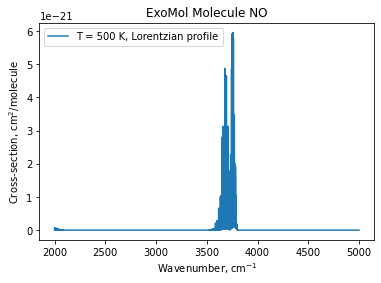

Cross sections plot saved.
Cross sections file saved.


In [51]:
t = Timer()
t.start()

# Initialise the iterator object.
trans_col_name = ['i', 'f', 'A_if', 'v_if']
trans_filenames = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')[0])
if len(trans_filenames) == 1:
    iterator = pd.read_csv(trans_filenames[0], compression='bz2', sep='\s+', header=None, 
                           names=trans_col_name, chunksize=100_000_000, encoding='utf-8')

elif len(trans_filenames) > 1:
    count = 0
    for trans_filename in tqdm(trans_filenames):
        lower = int(trans_filename.split('__')[2].split('.')[0].split('-')[0])
        upper = int(trans_filename.split('__')[2].split('.')[0].split('-')[1]) 
        if (lower <= int(min_wn) <= upper):
            lowerfile = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None, 
                                    names=trans_col_name, chunksize=100_000_000, encoding='utf-8')       
        elif (lower <= int(min_wn) <= upper):
            upperfile = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None, 
                                    names=trans_col_name, chunksize=100_000_000, encoding='utf-8')       
        
        elif (lower >= int(min_wn) and upper <= int(max_wn)):
            insiderfile = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None, 
                                      names=trans_col_name, chunksize=100_000_000, encoding='utf-8')     
        iterator = lowerfile.append(insiderfile).append(upperfile)              

# Depends on how many cores you want to utilise.
# Reserve 64 cores for our script.
max_processors = 64       
pool = multiprocessing.Pool(processes=max_processors)
f_list = []
for transfile_df in iterator:
    f = pool.apply_async(get_results, [transfile_df])
    f_list.append(f)
    if len(f_list) >= max_processors:
        for f in f_list:
            f.get()
            del f_list[:]

t.end()

%timeit
states_df = read_all_states(read_path)
trans_df = read_part_trans(read_path)
broad_df = read_broad(read_path)
wn_grid, A, v, Ep, Epp, gp, Jpp, gamma_L, n_air = part_linelist(states_df, trans_df, broad_df)
abscoef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
xsec_l = exomol_cross_section_Lorentzian(wn_grid, v, gamma, abscoef)
plot_exomol_xsec_Lorentzian(wn_grid, xsec_l)